<a href="https://colab.research.google.com/github/PPierzc/PracowniaEEG/blob/master/ERD_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ERD/S

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as ss
from scipy.signal import butter, filtfilt, iirnotch, freqz, lfilter, cheby2


!pip3 install obci_readmanager
from obci_readmanager.signal_processing.read_manager import ReadManager

!pip3 install --upgrade saffy==0.1.11
import saffy

sns.set()
sns.set_context("talk", font_scale=1.4)

    100% |████████████████████████████████| 61kB 2.4MB/s 
    100% |████████████████████████████████| 6.2MB 3.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/39/f9/f5/3e2fdef321f8e1f64061730c8ba2c81ad55c4b1b860b29d2dd
Successfully built mne
    100% |████████████████████████████████| 235kB 6.9MB/s 
    100% |████████████████████████████████| 10.1MB 871kB/s 
    100% |████████████████████████████████| 215kB 29.1MB/s 
    100% |████████████████████████████████| 24.8MB 1.4MB/s 
    100% |████████████████████████████████| 17.3MB 2.5MB/s 
jupyter-console 6.0.0 has requirement prompt-toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.15 which is incompatible.
google-colab 1.0.0 has requirement six~=1.11.0, but you'll have six 1.12.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found exist

## Utility Functions

In [0]:
def sin(t, f):
  return np.sin(2 * np.pi * f * t)

def noise(t, loc=0, scale=1):
  return np.random.normal(loc=loc, scale=scale, size=len(t))

## Wyznaczanie pasma $\mu$ i $\beta$.

In [0]:
def generate_signal():
  data = {
      'fs': 512,
      'num_channels': 3,
      'channel_names': ['C3', 'C4', 'd1'],
      'epochs': 1
  }
  
  T = 20
  t = np.arange(0, T, 1 / data['fs'])
  
  mu_freq = 10
  beta_freq = 23
  net_freq = 50
  
  data['data'] = np.zeros((data['epochs'], data['num_channels'], len(t)))
  
  for epoch in range(data['epochs']):
    data['data'][epoch][0] += (0.1 * t + 0.1) * sin(t, mu_freq)
    data['data'][epoch][0] += (0.1 * t + 0.1) * sin(t, beta_freq)
    data['data'][epoch][0] += sin(t, net_freq)
    data['data'][epoch][0] += 0.3 * noise(t)

    data['data'][epoch][1] += (0.1 * t + 0.1) * sin(t, mu_freq)
    data['data'][epoch][1] += (0.1 * t + 0.1) * sin(t, beta_freq)
    data['data'][epoch][1] += sin(t, net_freq)
    data['data'][epoch][1] += 0.3 * noise(t)

    data['data'][epoch][2][::5*data['fs']] = 1
    data['data'][epoch][2][0] = 0
    
  data['t'] = t
  data['tags'] = []
  
  return data

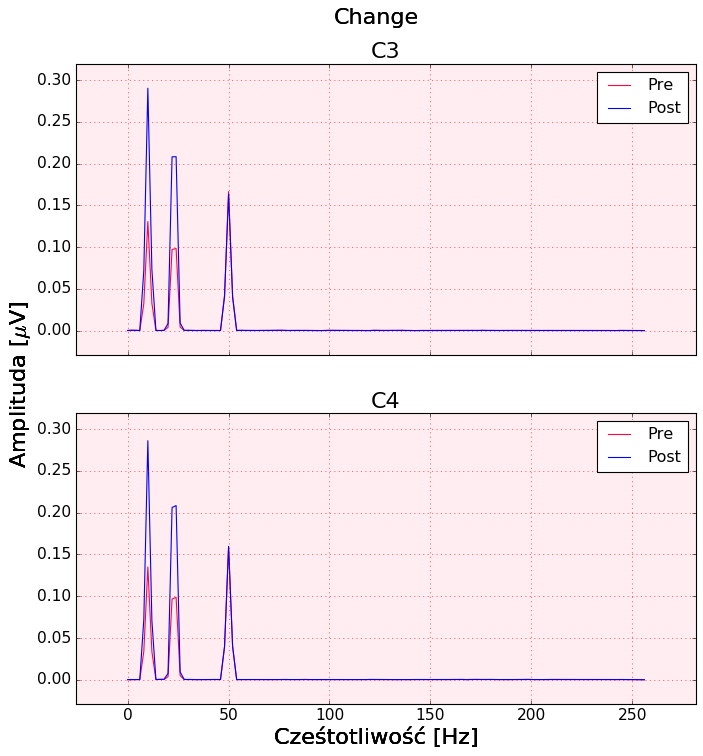

In [7]:
EEG = saffy.SignalManager(generator=generate_signal())

EEG.set_tags_from_channel('d1')
EEG.remove_channel('d1')

PRE_EEG = EEG.copy('pre')
PRE_EEG.set_epochs_from_tags(-4, -2)

PRE_EEG.welch_spectrum()
PRE_EEG.spectrum = np.mean(PRE_EEG.spectrum, axis=0)
PRE_EEG.spectrum = np.reshape(PRE_EEG.spectrum, (1, *PRE_EEG.spectrum.shape))

POST_EEG = EEG.copy('post')
POST_EEG.set_epochs_from_tags(0.5, 2.5)

POST_EEG.welch_spectrum()
POST_EEG.spectrum = np.mean(POST_EEG.spectrum, axis=0)
POST_EEG.spectrum = np.reshape(POST_EEG.spectrum, (1, *POST_EEG.spectrum.shape))

fig, ax = plt.subplots(
    nrows=max([PRE_EEG.num_channels, POST_EEG.num_channels]),
    ncols=1,
    sharex=True,
    sharey=True,
    figsize=(10, 10)
)

PRE_EEG.graphics_spectrum_plot(
    fig,
    ax,
    'Change',
    label='Pre'
)

POST_EEG.graphics_spectrum_plot(
    fig,
    ax,
    color='#0000ff',
    label='Post'
)

for a in ax:
  a.legend()

plt.show()
plt.close()


## Wyznaczenie przebiegu czasowego ERD i ERS

Zaprojektuj filtry pasmowo przepustowe (Chebyszewa 2 rodzaju) zgodne z wyznaczonymi pasmami.

Zbadaj funkcje przenoszenia i odpowiedzi impulsowej.

Powycinaj sygnały od −5 do +5 sekund (wszystkie kanały). Przefiltruj każdą realizację.

Oblicz moc chwilową za pomocą transformaty Hilberta (kwadrat amplitudy chwilowej).

Uśrednij moc chwilową po realizacjach.

Oblicz względną zmianę mocy chwilowej względem czasu −4 do −2. W ten sposób otrzymasz przebieg ERD i ERS w czasie.

Wykreśl ERD i ERS w układzie topograficznym. (Rozmieść subploty tak, aby z w przybliżeniu odpowiadały pozycjom elektrod).

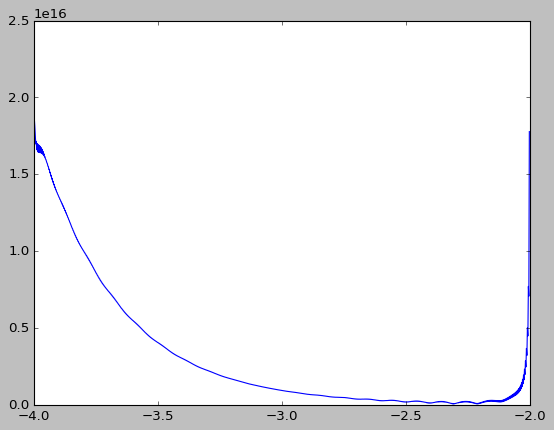

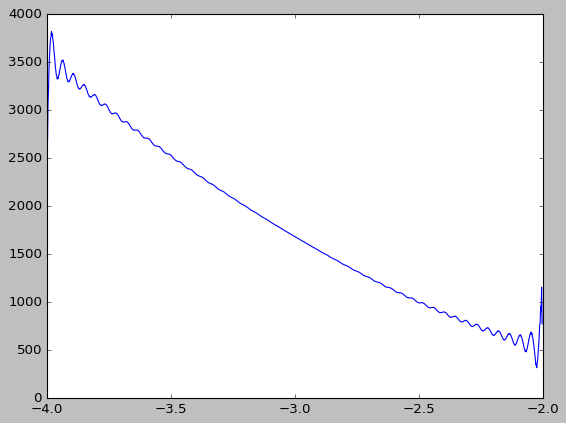

In [8]:
EEG = saffy.SignalManager(generator=generate_signal())

EEG.set_tags_from_channel('d1')
EEG.remove_channel('d1')
EEG.set_epochs_from_tags(-5, 5)

MU_EEG = EEG.copy('mu')
BETA_EEG = EEG.copy('beta')

mu_freq = 10
beta_freq = 23

MU_EEG.cheb2_notch_filter(mu_freq, btype='bandpass')
BETA_EEG.cheb2_notch_filter(beta_freq, btype='bandpass')

MU_EEG.extract_time_range(-4, -2)
BETA_EEG.extract_time_range(-4, -2)

MU_EEG.hilbert_transform(phase_freq=mu_freq)
MU_EEG.hilbert['power'] = np.mean(MU_EEG.hilbert['power'], axis=0)
MU_EEG.hilbert['power'] = np.reshape(MU_EEG.hilbert['power'], (1, *MU_EEG.hilbert['power'].shape))

BETA_EEG.hilbert_transform(phase_freq=beta_freq)
BETA_EEG.hilbert['power'] = np.mean(BETA_EEG.hilbert['power'], axis=0)
BETA_EEG.hilbert['power'] = np.reshape(BETA_EEG.hilbert['power'], (1, *BETA_EEG.hilbert['power'].shape))

plt.plot(MU_EEG.t, MU_EEG.hilbert['power'][0, 0, :])
plt.show()

plt.plot(BETA_EEG.t, BETA_EEG.hilbert['power'][0, 0, :])
plt.show()



### Hjort

In [0]:
class HjortPlugin(saffy.PluginManager):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def custom_func():
    print('S')

saffy.SignalManager.register_plugin(HjortPlugin)

In [11]:
EEG = saffy.SignalManager(generator=generate_signal())

saffy.SignalManager.custom_func()

S
